In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]

import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stats
from tqdm import tqdm
import pdb
import copy

import sys
import os

#########################
# Experiment parameters #
#########################
from sklearn.base import clone
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


sys.path.append('../third_party')
sys.path.append('../methods')
from methods_experiment import oc, bc, clra

## Data generation

In [2]:
from models import GaussianMixture, ToyModel

random_state = 2021

p = 50        # Number of features
a = 0.5         # Signal amplitude

model = GaussianMixture(p, a, random_state=random_state)

n = 500          # Number of observations
n_test = 2000     # Number of test points
purity = 0.9     # Proportion of inliers
purity_test = 0.5 # Proportion of inliers in test set

X, Y = model.sample(n, purity=purity)
X_test, Y_test = model.sample(n_test, purity=purity_test)

print("Number of inliers in training/calibration data: {}.".format(np.sum(Y==0)))
print("Number of outliers in training/calibration data: {}.".format(np.sum(Y==1)))

print("Number of inliers in test data: {}.".format(np.sum(Y_test==0)))
print("Number of outliers in test data: {}.".format(np.sum(Y_test==1)))

Number of inliers in training/calibration data: 450.
Number of outliers in training/calibration data: 50.
Number of inliers in test data: 1000.
Number of outliers in test data: 1000.


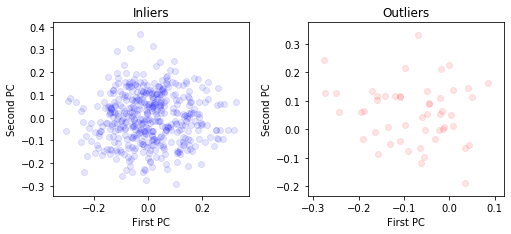

In [3]:
## Perform nonlinear PCA on an independent set of clean data
from sklearn.decomposition import KernelPCA

X_clean, _ = model.sample(n, purity=1)

pca = KernelPCA(kernel="rbf", n_components=2, gamma=0.01)
pca.fit(X_clean)

## Apply the nonlinear PCA separately to the inliers and outliers
X_in = X[Y==0]
pcs_in = pca.transform(X_in)

X_out = X[Y==1]
pcs_out = pca.transform(X_out)

## Plot the PCA results
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].scatter(pcs_in[:,0], pcs_in[:,1], alpha=0.1, color="blue")
axs[1].scatter(pcs_out[:,0], pcs_out[:,1], alpha=0.1, color="red")  
#axs[0].set_xlim(-0.5,0.5)
#axs[1].set_xlim(-0.5,0.5)
#axs[0].set_ylim(-0.5,0.5)
#axs[1].set_ylim(-0.5,0.5)
axs[0].set_xlabel("First PC")
axs[0].set_ylabel("Second PC")
axs[1].set_xlabel("First PC")
axs[1].set_ylabel("Second PC")
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
plt.show()

## Conformal p-values via one-class classification

In [4]:
# Choose a one-class classifier algorithm
algorithm_oneclass = "Neighbors"

# Initialize the one-class classifier with desired hyper-parameters
if algorithm_oneclass == "SVM":
    contamination = 0.001
    contamination = min(max(contamination,0.004),0.1)
    bbox_occ = svm.OneClassSVM(nu=contamination, kernel="rbf", gamma=0.1)
elif algorithm_oneclass == "IForest":
    contamination = 0.001
    contamination = min(max(contamination,0.004),0.1)
    bbox_occ = IsolationForest(random_state=random_state, contamination=contamination)
elif algorithm_oneclass == "Neighbors":
    contamination = 0.001
    contamination = min(max(contamination,0.004),0.1)
    bbox_occ = LocalOutlierFactor(novelty=True, contamination=contamination)
else:
    print("Error: unknown algorithm: {:s}!".format(algorithm_oneclass))

In [5]:
from methods import OneClassConformal

# Extract the inliers from the data
X_in = X[Y==0]

# Compute the p-values
method_oneclass = OneClassConformal(X_in, bbox_occ, calib_size=0.5)
pvals_oneclass = method_oneclass.compute_pvalues(X_test)

Fitting the black-box model on 225 data points... done.
Calculating conformity scores for 225 hold-out data points... done.
Calculating conformity scores for 2000 test points... done.


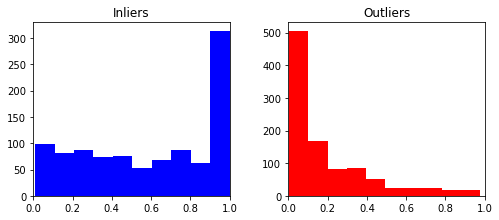

In [6]:
## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_oneclass[Y_test==0], color="blue")
axs[1].hist(pvals_oneclass[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

## Conformal p-values via binary classification

In [7]:
from sklearn.ensemble import RandomForestClassifier 

# Choose a one-class classifier algorithm
algorithm_binary = "Forest"

# Initialize the one-class classifier with desired hyper-parameters
if algorithm_binary == "Forest":
    bbox_bc = RandomForestClassifier(max_depth=2, random_state=random_state)
else:
    print("Error: unknown algorithm: {:s}!".format(algorithm_binary))

In [8]:
from methods import BinaryConformal

# Extract the inliers from the data
X_in = X[Y==0]
X_out = X[Y==1]

# Compute the p-values
method_binary = BinaryConformal(X_in, X_out, bbox_bc, calib_size=0.5)
pvals_binary = method_binary.compute_pvalues(X_test)

Fitting the black-box model on 225 inliers and 50 outliers... done.
Calculating conformity scores for 225 hold-out inliers... done.
Calculating conformity scores for 2000 test points... done.


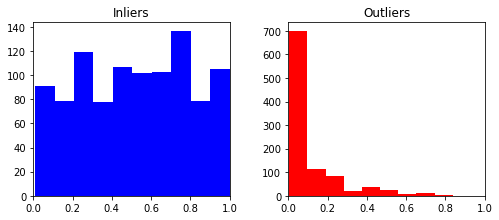

In [9]:
## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_binary[Y_test==0], color="blue")
axs[1].hist(pvals_binary[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

## Conformal p-values via weighted one-class classification

In [10]:
# Use the same type of black-box model for inliers and outliers
bbox_occ_in = copy.deepcopy(bbox_occ)
bbox_occ_out = copy.deepcopy(bbox_occ)

In [11]:
from methods import WeightedOneClassConformal

# Extract the inliers from the data
X_in = X[Y==0]
X_out = X[Y==1]

# Compute the p-values
method_woc = WeightedOneClassConformal(X_in, X_out, bbox_occ_in, bbox_occ_out, calib_size=0.5)

Fitting the black-box model on 225 data points... done.
Fitting the black-box model on 25 data points... done.


In [12]:
pvals_woneclass = method_woc.compute_pvalues(X_test)

100%|██████████| 2000/2000 [00:00<00:00, 3765.83it/s]


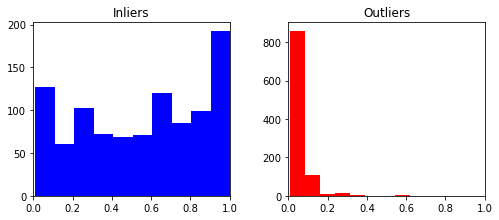

In [13]:
## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_woneclass[Y_test==0], color="blue")
axs[1].hist(pvals_woneclass[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

## Compare all p-values

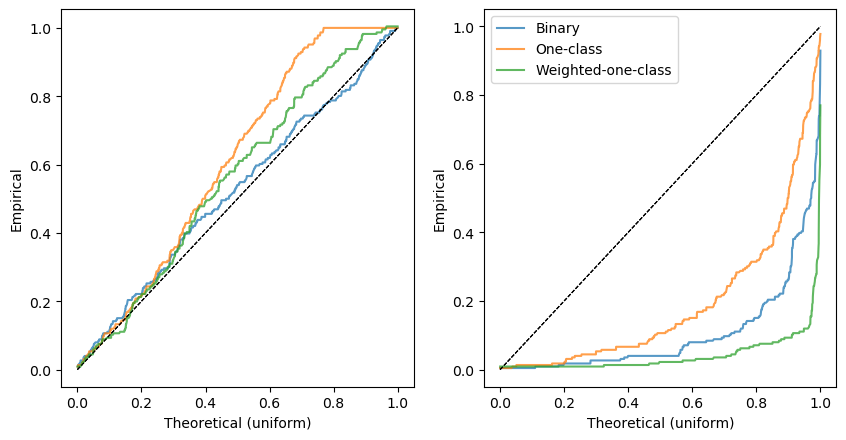

In [14]:
def qq_plot(data, reference, ax, label=None, logarithm=False):
    sample_size = len(data)
    qq = np.ones([sample_size, 2])
    np.random.shuffle(data)
    qq[:, 0] = np.sort(reference)
    qq[:, 1] = np.sort(data[0:sample_size])
    ax.plot(qq[:,0], qq[:,1], label=label, alpha=0.75)
    ax.plot([0,1], [0,1], color="black", linewidth=0.75, linestyle="dashed")
    ax.set_xlabel("Theoretical (uniform)")
    ax.set_ylabel("Empirical")
    if logarithm:
        ax.set_xscale('log')
        ax.set_yscale('log')        
        
fig, axs = plt.subplots(1,2, figsize=(10,5), dpi= 100)

logarithm = False
U = np.random.uniform(size = (len(Y_test),))
for y in [0,1]:
    qq_plot(pvals_binary[Y_test==y], U[Y_test==y], axs[y], label="Binary", logarithm=logarithm)
    qq_plot(pvals_oneclass[Y_test==y], U[Y_test==y], axs[y], label="One-class", logarithm=logarithm)
    qq_plot(pvals_woneclass[Y_test==y], U[Y_test==y], axs[y], label="Weighted-one-class", logarithm=logarithm)

plt.legend()
plt.show()